In [1]:
import os, sys
import pandas as pd
import numpy as np
from matplotlib import animation

sys.path.append(os.path.join('..','funcs'))
import loading_fun as lf
import visualization_fun as vf
import mapping_fun as mf
import register_icp as icp

sys.path.append('utils')
import register_icp as icp2
import icp_known_correspondence as icp1

from matplotlib import rc

from importlib import reload

In [2]:
gopi_file = os.path.join('..', 'Gopi_Trajectories', 'raw', 'sample-1-cell-tracks.csv')
output_folder = os.path.join('..', 'output')

tracks_file = os.path.join(output_folder, 'trajectories.csv')

gene_markers = ['HAND2','EMX3','SOX10','SP5L','NKX2.4B']

tp = 12.
alpha = 0.9
file_hcr_mapped = os.path.join('..','HCR_time_course','mapped_transfer_hpf12.h5ad')

In [3]:
adata_hcr, n_cells_hcr, n_genes_hcr = lf.load_scrnaseq(file_hcr_mapped)

In [4]:
### load tracks    
if not os.path.exists(tracks_file):
    cells_tl = lf.prepare_tracks(gopi_file)
    cells_tl.to_csv(tracks_file, index=False)
else:
    cells_tl = pd.read_csv(tracks_file)

t_idx = cells_tl[cells_tl.t==tp].t_idx.values[0]

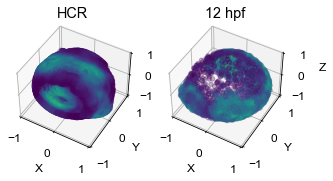

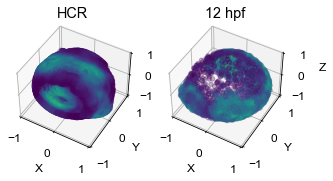

In [5]:
vf.visualize_cells(adata_hcr.obs, cells_tl[cells_tl.t==tp], tps=[t_idx], elev=45, azim_init=-60)

# 1. Perform ICP registration

## 1.1 Manually select matching points in the two datasets to make coarse registration

### 1.1.1 Interactively select the points for coarse registration

In [6]:
point_list = [[],[]]

In [7]:
%matplotlib qt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

dataset_index = 0

# taken from: https://stackoverflow.com/questions/58218482/annotate-3d-scatter-plot-on-pick-event
def getxyz(event):
#     print(event.mouseevent)

    if event.mouseevent.button==3:
        if len(point_list[dataset_index])>0:
            point_list[dataset_index].pop()
            print("Removed last point: ListLen:%d"%len(point_list[dataset_index]))
        return
    if event.mouseevent.button!=1:
        print('Not left click!')
        return
#     if len(event.ind)>1:
#         print('Multiple points selected!')
#         return
    
    xx=event.mouseevent.x
    yy=event.mouseevent.y
    
    #magic from https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
    x2, y2, z2=proj3d.proj_transform(x[0], y[0], z[0], plt.gca().get_proj())
    x3, y3 = ax.transData.transform((x2, y2))
    d=np.sqrt ((x3 - xx)**2 + (y3 - yy)**2)
    
    #find the closest by searching for min distance.
    #All glory to https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
    imin=0
    dmin=10000000
    for i in range(len(x)):
        #magic from https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
        x2, y2, z2=proj3d.proj_transform(x[i], y[i], z[i], plt.gca().get_proj())
        x3, y3 = ax.transData.transform((x2, y2))
        #the distance magic from https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
        d=np.sqrt ((x3 - xx)**2 + (y3 - yy)**2)
        #We find the distance and also the index for the closest datapoint
        if d< dmin:
            dmin=d
            imin=i

    point_list[dataset_index].append([x[imin], y[imin], z[imin]])
    print("ListLen:%d"%len(point_list[dataset_index]),"X:%.2f"%x[imin], " Y:%.2f"%y[imin], " Z:%.2f"%z[imin], " PointIdx:", imin)

    return

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

a = adata_hcr.obs.sample(5000)
a = a[['x','y','z']].to_numpy()
x = a[:,0]
y = a[:,1]
z = a[:,2]
scatter = ax.scatter(x,y,z,alpha=1,picker=True)

# i=0
# for p in a:
#     text = str(i) + ':' + str(p[0])[:5] + ', ' + str(p[1])[:5] + ', ' + str(p[2])[:5]
#     ax.text(p[0],p[1],p[2], text, fontsize=5)
#     i+=1

fig.canvas.mpl_connect('pick_event', getxyz)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.set_xlabel('X ax')
ax.set_ylabel('Y ax')
ax.set_zlabel('Z ax')
ax.set_box_aspect([1,1,1])


ListLen:1 X:0.88  Y:-0.06  Z:-0.56  PointIdx: 4922
ListLen:2 X:0.27  Y:-0.02  Z:0.91  PointIdx: 4965
ListLen:3 X:-0.95  Y:0.15  Z:0.26  PointIdx: 2297
ListLen:4 X:-0.47  Y:-0.12  Z:-0.85  PointIdx: 2640


In [8]:
%matplotlib qt
from mpl_toolkits.mplot3d import proj3d

dataset_index=1

# taken from: https://stackoverflow.com/questions/58218482/annotate-3d-scatter-plot-on-pick-event
def getxyz(event):
#     print(event.mouseevent)

    if event.mouseevent.button==3:
        if len(point_list[dataset_index])>0:
            point_list[dataset_index].pop()
            print("Removed last point: ListLen:%d"%len(point_list[dataset_index]))
        return
    if event.mouseevent.button!=1:
        print('Not left click!')
        return
#     if len(event.ind)>1:
#         print('Multiple points selected!')
#         return
    
    xx=event.mouseevent.x
    yy=event.mouseevent.y
    
    #magic from https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
    x2, y2, z2=proj3d.proj_transform(x[0], y[0], z[0], plt.gca().get_proj())
    x3, y3 = ax.transData.transform((x2, y2))
    d=np.sqrt ((x3 - xx)**2 + (y3 - yy)**2)
    
    #find the closest by searching for min distance.
    #All glory to https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
    imin=0
    dmin=10000000
    for i in range(len(x)):
        #magic from https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
        x2, y2, z2=proj3d.proj_transform(x[i], y[i], z[i], plt.gca().get_proj())
        x3, y3 = ax.transData.transform((x2, y2))
        #the distance magic from https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
        d=np.sqrt ((x3 - xx)**2 + (y3 - yy)**2)
        #We find the distance and also the index for the closest datapoint
        if d< dmin:
            dmin=d
            imin=i

    point_list[dataset_index].append([x[imin], y[imin], z[imin]])
    print("ListLen:%d"%len(point_list[dataset_index]),"X:%.2f"%x[imin], " Y:%.2f"%y[imin], " Z:%.2f"%z[imin], " PointIdx:", imin)

    return

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

a = cells_tl[cells_tl.t==tp]
a = a[['x','y','z']].to_numpy()
x = a[:,0]
y = a[:,1]
z = a[:,2]
scatter = ax.scatter(x,y,z,alpha=1,picker=True)

# i=0
# for p in a:
#     text = str(i) + ':' + str(p[0])[:5] + ', ' + str(p[1])[:5] + ', ' + str(p[2])[:5]
#     ax.text(p[0],p[1],p[2], text, fontsize=5)
#     i+=1

fig.canvas.mpl_connect('pick_event', getxyz)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.set_xlabel('X ax')
ax.set_ylabel('Y ax')
ax.set_zlabel('Z ax')
ax.set_box_aspect([1,1,1])


ListLen:1 X:-0.75  Y:-0.87  Z:-0.07  PointIdx: 921
ListLen:2 X:0.75  Y:-0.63  Z:0.25  PointIdx: 2141
ListLen:3 X:0.86  Y:0.56  Z:-0.28  PointIdx: 3237
ListLen:4 X:-0.46  Y:0.95  Z:-0.09  PointIdx: 2210


### 1.1.2 Make a first coarse registration

In [9]:
point_list = np.array(point_list)

R_coarse, T_coarse = icp1.icp_known_correspondence(point_list[1],point_list[0])
result = (T_coarse + np.matmul(R_coarse,point_list[1].transpose())).transpose()

if np.allclose(result.transpose(),point_list[0].transpose(), rtol=50):
    print("transformation is correct!")
else:
    print("transformation is wrong...")
    
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
s1=ax.scatter(point_list[0,:,0],point_list[0,:,1],point_list[0,:,2], alpha=1, c='blue')
s2=ax.scatter(point_list[1,:,0],point_list[1,:,1],point_list[1,:,2], alpha=1, c='red')
s3=ax.scatter(result[:,0],result[:,1],result[:,2], alpha=1, c='green')
for i in range(len(result)):
    ax.plot([point_list[1,i,0],result[i,0]],
           [point_list[1,i,1],result[i,1]],
           [point_list[1,i,2],result[i,2]],c='k')
ax.legend([s1,s2,s3],['target','source','moved'])
ax.set_xlabel('X ax')
ax.set_ylabel('Y ax')
ax.set_zlabel('Z ax')
ax.set_box_aspect([1,1,1])

transformation is correct!


In [10]:
### Perform ICP

b = cells_tl[['x','y','z']].to_numpy()
b = (T_coarse + np.matmul(R_coarse,b.transpose())).transpose()

cells_tl['x'] = b[:,0]
cells_tl['y'] = b[:,1]
cells_tl['z'] = b[:,2]

adata_live12hpf = cells_tl[cells_tl.t==tp]

%matplotlib notebook

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(adata_live12hpf.x, 
           adata_live12hpf.y, 
           adata_live12hpf.z, 
           alpha=0.1, c=adata_live12hpf.density, cmap='hot')
ax.scatter(adata_hcr.obs.x, 
           adata_hcr.obs.y, 
           adata_hcr.obs.z, 
           alpha=0.1, c=adata_hcr.obs.density, cmap='viridis')

ax.set_xlabel('X ax')
ax.set_ylabel('Y ax')
ax.set_zlabel('Z ax')
ax.set_box_aspect([1,1,1])


## 1.2 Perform finer registration using 1000 points

In [11]:
### compute transformation with ICP - select 1000 random points from both datasets
reload(icp2)

new_dfs = [i.sample(1000) for i in [adata_live12hpf,adata_hcr.obs]]

a = new_dfs[0][['x','y','z']].to_numpy()
b = new_dfs[1][['x','y','z']].to_numpy()

T,_,_,_ = icp2.icp(b, a, max_iterations=1000, tolerance=1e-45)
# T = funcs.simpleicp(a, b, correspondences=10000, neighbors=10, min_planarity=0.3, min_change=.1,
#               max_iterations=1000)

### Perform ICP

A = adata_hcr.obs[['x','y','z']].to_numpy()
A = icp2.cloud_transform(A, T)

adata_hcr.obs['x'] = A[:,0]
adata_hcr.obs['y'] = A[:,1]
adata_hcr.obs['z'] = A[:,2]

In [12]:
%matplotlib notebook

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(adata_live12hpf.x, 
           adata_live12hpf.y, 
           adata_live12hpf.z, 
           alpha=0.1, c=adata_live12hpf.density, cmap='hot')
ax.scatter(adata_hcr.obs.x, 
           adata_hcr.obs.y, 
           adata_hcr.obs.z, 
           alpha=0.1, c=adata_hcr.obs.density, cmap='viridis')

ax.set_xlabel('X ax')
ax.set_ylabel('Y ax')
ax.set_zlabel('Z ax')
ax.set_box_aspect([1,1,1])


# 2. Perform inhomogenous warping with Vedo

In [13]:
import vedo, tqdm

In [25]:
# define anchor points as average on a grid
adata_live12hpf_forwarp = adata_live12hpf[np.abs(adata_live12hpf.y)<0.8]

point1_o = adata_live12hpf_forwarp[['x','y','z']].to_numpy()
point1_o_color = adata_live12hpf_forwarp[['density']].to_numpy()
point2_o = [adata_hcr.obs[['x','y','z']].to_numpy()]
point2_o_color = adata_hcr.obs[['density']].to_numpy()

grid_size = .5
pbar = tqdm.tqdm(range(20))
for n in pbar:
    pbar.set_description("grid_size: %.3f"%grid_size)
#     print(grid_size)
    bins = np.arange(-1,1.1,grid_size)
    grid_size = grid_size*0.95
    n_min = 10

    source = []
    target = []

    a = []
    for i in range(len(bins)-1):
        for j in range(len(bins)-1):
            for k in range(len(bins)-1):
                p_s = point2_o[-1]
                s = p_s[(p_s[:,0]>bins[i])&(p_s[:,0]<=bins[i+1])&
                        (p_s[:,1]>bins[j])&(p_s[:,1]<=bins[j+1])&
                        (p_s[:,2]>bins[k])&(p_s[:,2]<=bins[k+1])]

                p_t = point1_o
                t = p_t[(p_t[:,0]>bins[i])&(p_t[:,0]<=bins[i+1])&
                        (p_t[:,1]>bins[j])&(p_t[:,1]<=bins[j+1])&
                        (p_t[:,2]>bins[k])&(p_t[:,2]<=bins[k+1])]

                if (s.shape[0]>n_min)&(t.shape[0]>n_min):
                    source.append(np.mean(s,0))
                    target.append(np.mean(t,0))
    source = np.array(source)
    target = np.array(target)

    p2 = vedo.Points(point2_o[-1]).c('green4')
    newpt2 = p2.clone().warp(source, target, mode='3d', sigma=1)
    point2_o.append(newpt2.points())

#     p2 = vedo.Points(point2[-1]).c('green4')
#     newpt2 = p2.clone().warp(source, target, mode='3d', sigma=1)
#     point2.append(newpt2.points())

# point2 = np.array(point2)
point2_o = np.array(point2_o)

grid_size: 0.189: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.03it/s]


In [27]:
%matplotlib notebook

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(adata_live12hpf_forwarp.x, 
           adata_live12hpf_forwarp.y, 
           adata_live12hpf_forwarp.z, 
           alpha=0.5, c=adata_live12hpf_forwarp.density, cmap='hot')
ax.scatter(point2_o[-1][:,0], 
           point2_o[-1][:,1], 
           point2_o[-1][:,2],  
           alpha=0.5, c=adata_hcr[:,['meox1']].X[:,0], cmap='viridis')

ax.set_xlabel('X ax')
ax.set_ylabel('Y ax')
ax.set_zlabel('Z ax')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.set_box_aspect([1,1,1])


In [28]:
adata_hcr.obs['x'] = point2_o[-1,:,0]
adata_hcr.obs['y'] = point2_o[-1,:,1]
adata_hcr.obs['z'] = point2_o[-1,:,2]

# Build timelapse integrated dataset

In [29]:
cells_tl

,x,y,z,ID,t_idx,germ_layer,t,density
0,0.826320,-0.225129,-0.313474,1,1,1,4.00,6.0
1,0.790685,-0.251946,-0.344549,1,2,1,4.03,7.0
2,0.785666,-0.285109,-0.347279,1,3,1,4.06,6.0
3,0.782713,-0.311292,-0.330293,1,4,1,4.09,6.0
4,0.778521,-0.295772,-0.334581,1,5,1,4.12,8.0
...,...,...,...,...,...,...,...,...
1727519,-0.624825,-0.289978,-1.053990,101376,420,3,17.00,20.0
1727520,0.090987,-0.631070,-0.562834,101377,417,3,16.91,3.0
1727521,0.089427,-0.630942,-0.565605,101377,418,3,16.94,3.0
1727522,0.081940,-0.632867,-0.563151,101377,419,3,16.97,3.0


In [30]:
adata_hcr

AnnData object with n_obs × n_vars = 20663 × 5071
    obs: 'x', 'y', 'z', 'density', 'h2bgfp', 'batch', 'TissueName', 'ClusterName'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'selected_gene'
    uns: 'batch_colors'
    obsm: 'X_umap', 'rep'

In [31]:
from sklearn.neighbors import NearestNeighbors

query = cells_tl[cells_tl.t==tp][['x','y','z']].to_numpy()
ref = adata_hcr.obs[['x','y','z']].to_numpy()

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(ref)
distances, indices = nbrs.kneighbors(query)
    
tissuenames = list(adata_hcr.obs.TissueName)
clusternames = list(adata_hcr.obs.ClusterName)

cell_ids = list(cells_tl[cells_tl.t==tp].ID)

id2id = []
id2tissue = []
id2cluster = []
for i, cell_id in enumerate(cell_ids):
    dist = distances[i][0]
    ind = indices[i][0]
    
    if dist<0.1:
        id2id.append(cell_id)
        id2tissue.append( tissuenames[ind] )
        id2cluster.append( clusternames[ind] )
    else:
        id2id.append(cell_id)
        id2tissue.append( 'NaN' )
        id2cluster.append( 'NaN' )
    


In [32]:
id2tissue

['NaN',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Hindbrain / Spinal Cord',
 'NaN',
 'NaN',
 'Hindbrain / Spinal Cord',
 'Epidermal',
 'Epidermal',
 'NaN',
 'Hindbrain / Spinal Cord',
 'Hindbrain / Spinal Cord',
 'Hindbrain / Spinal Cord',
 'NaN',
 'NaN',
 'NaN',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Hindbrain / Spinal Cord',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Epidermal',
 'Hindbrain / Spinal Cord',
 'NaN',
 'NaN',
 'Hindbrain / Spinal Cord',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Hindbrain / Spinal Cord',
 'Neural Crest',
 'NaN',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Hindbrain / Spinal Cord',
 'NaN',
 'Hindbrain / Spinal Cord',
 'Hindbrain / Spinal Cord',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'Hindbrain / Spinal Cord',
 'Hindbrain / Spinal Cord',
 'Midbrain',
 'Neural Crest',
 'NaN',
 'Epidermal',
 'Hindbrain / Spinal Cord',
 'Forebrain / Optic',
 'Hindbrain / Spinal Cord',
 'NaN',
 'NaN',
 'NaN',
 'NaN',
 'Midbr

In [33]:
ids = cells_tl.ID.values

tissuenames = ['' for i in ids]
clusternames = []
j = 0
for c_id in tqdm.tqdm(ids):
    if c_id in id2id:
        tissuenames[j] = id2tissue[id2id.index(c_id)]
#         clusternames.append( is2cluster[c_id] )
    else:
        tissuenames[j] = 'NaN'
#         clusternames.append( 'NaN' )
    j+=1

cells_tl['TissueName'] = tissuenames
# cells_tl['ClusterName'] = clusternames

cells_tl.to_csv('live_mapped.csv')

100%|██████████████████████████████████████████████████████████████████████| 1727524/1727524 [17:23<00:00, 1655.19it/s]


# Visualize

In [9]:
import tqdm
import matplotlib.pyplot as plt

cells_tl = pd.read_csv('live_mapped.csv')

cells_tl.TissueName = [str(i) for i in tqdm.tqdm(cells_tl.TissueName)]

100%|███████████████████████████████████████████████████████████████████| 1727524/1727524 [00:00<00:00, 1886868.24it/s]


In [10]:
df = cells_tl[cells_tl.t==12.]

[Text(1, 0, 'Ecto'), Text(2, 0, 'Meso'), Text(3, 0, 'Endo')]

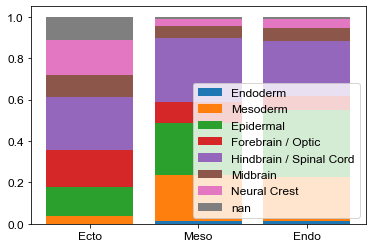

In [11]:
gls = [1,2,3] # 1=ecto, 2=meso, 3=endo
composition = [[0],[0],[0]]
tissuenames = ['Endoderm', 'Mesoderm', 'Epidermal', 'Forebrain / Optic',
               'Hindbrain / Spinal Cord', 'Midbrain', 'Neural Crest', 'nan']
for gl in gls:
    
    df_gl = df[df.germ_layer==gl]
    
    for tn in tissuenames:
        composition[gl-1].append(len(df_gl[df_gl.TissueName==tn])/len(df_gl))

composition = np.array(composition).transpose()

fig, ax = plt.subplots()

bottom = np.array([0.,0.,0.])
for i, c in enumerate(composition[1:]):
    bottom += composition[i]
    ax.bar(gls, c, bottom=bottom, label=tissuenames[i])
ax.legend()
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Ecto','Meso','Endo'])

[Text(1, 0, 'GL'), Text(2, 0, 'TN')]

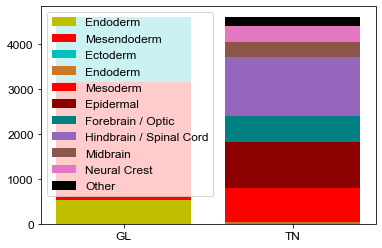

In [12]:
palette1 = ['c', 'r', 'y',]
palette2=[
    '#CC7722',
    '#FF0000',
    '#8B0000',
    '#008080',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    'k'
]

# 1=ecto, 2=meso, 3=endo
glnames = ['Ectoderm', 'Mesendoderm', 'Endoderm']
df['glname'] = [glnames[i-1] for i in df.germ_layer]

newtns = df.TissueName.values
for i in range(len(newtns)):
    if newtns[i] == 'nan':
        newtns[i] = 'Other'
df.TissueName = newtns

comp_gls = []
for gl in glnames:    
    df_gl = df[df.glname==gl]
    comp_gls.append(len(df_gl))

tns = ['Endoderm', 'Mesoderm', 'Epidermal', 'Forebrain / Optic',
               'Hindbrain / Spinal Cord', 'Midbrain', 'Neural Crest', 'Other']
comp_tns = []
for tn in tns:    
    df_tn = df[df.TissueName==tn]
    comp_tns.append(len(df_tn))
    
    
    
##################
fig, ax = plt.subplots()

bottom = 0
for i in range(len(glnames[::-1])):
    ax.bar([1], comp_gls[::-1][i], bottom=bottom, label=glnames[::-1][i], color = palette1[::-1][i])
    bottom += comp_gls[::-1][i]

bottom = 0
for i in range(len(tns)):
    ax.bar([2], comp_tns[i], bottom=bottom, label=tns[i], color = palette2[i])
    bottom += comp_tns[i]

ax.legend()
ax.set_xticks([1,2])
ax.set_xticklabels(['GL','TN'])

100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [00:03<00:00, 67.22it/s]


[Text(42, 0, '2.0'),
 Text(84, 0, '4.0'),
 Text(126, 0, '6.0'),
 Text(168, 0, '8.0'),
 Text(210, 0, '10.0'),
 Text(252, 0, '12.0')]

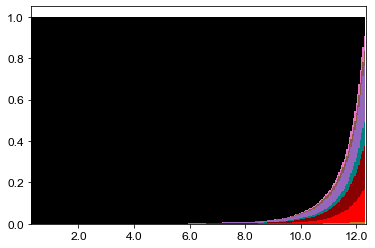

In [15]:
newtns = cells_tl.TissueName.values
for i in range(len(newtns)):
    if newtns[i] == 'nan':
        newtns[i] = 'Other'
cells_tl.TissueName = newtns

palette2=[
    '#CC7722',
    '#FF0000',
    '#8B0000',
    '#008080',
    '#9467bd',
    '#8c564b',
    '#e377c2',
   'k'
]

fig, ax = plt.subplots()

t_idxs = list(set(cells_tl.t_idx))
tns = ['Endoderm', 'Mesoderm', 'Epidermal', 'Forebrain / Optic',
               'Hindbrain / Spinal Cord', 'Midbrain', 'Neural Crest', 'Other']

for t_idx in tqdm.tqdm(range(259)):
    cells = cells_tl[cells_tl.t_idx == t_idx]
    comp_tns = []
    for tn in tns:    
        cells_tn = cells[cells.TissueName==tn]
        comp_tns.append(len(cells_tn))
    comp_tns = np.array(comp_tns)/np.sum(comp_tns)
    ##################
    bottom = 0
    for i in range(len(tns)):
        ax.bar([t_idx], comp_tns[i], bottom=bottom, label=tns[i], color = palette2[i], width=1, alpha=1., edgecolor = "none")
        bottom += comp_tns[i]
        
ax.set_xlim((6,259))
ax.set_xticks([42,84,126,168,210,252])
ax.set_xticklabels(2*np.array([42,84,126,168,210,252])/42)
# ax.legend()

In [109]:
np.min(cells_tl.t_idx)

1